In [2]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [3]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"USAccDeaths.csv")
bd.pop("Unnamed: 0")
bd

,time,value
0,1973.000000,9007
1,1973.083333,8106
2,1973.166667,8928
3,1973.250000,9137
4,1973.333333,10017
...,...,...
67,1978.583333,9827
68,1978.666667,9110
69,1978.750000,9070
70,1978.833333,8633


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


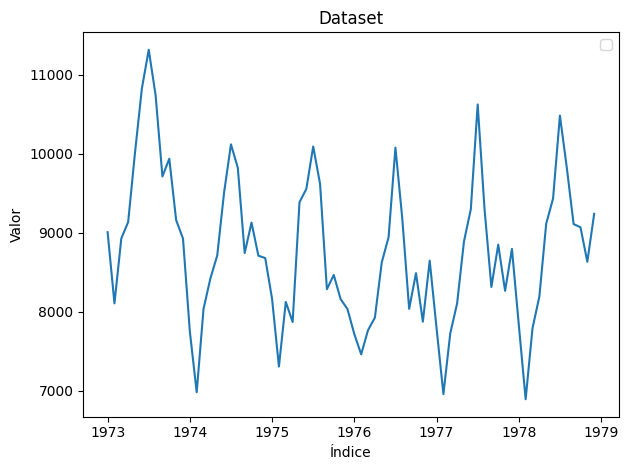

time
1973-01-01   -0.044068
1973-01-31   -0.451299
1973-03-02   -0.079774
1973-04-02    0.014689
1973-05-02    0.412429
                ...   
1978-08-01    0.326554
1978-09-01    0.002486
1978-10-01   -0.015593
1978-11-01   -0.213107
1978-12-01    0.061243
Name: value, Length: 72, dtype: float64

In [4]:
plt.title('Dataset')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.plot(bd["time"],bd["value"])
plt.legend()
plt.tight_layout()
plt.show()
from datetime import datetime, timedelta
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    base_date = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - base_date).days
    days_to_add = int(days_in_year * remainder)
    return base_date + timedelta(days=days_to_add)

decimal_years = bd["time"]
dates = [decimal_year_to_date(decimal_year) for decimal_year in decimal_years]

formatted_dates = [date.strftime("%Y-%m-%d") for date in dates]
bd["time"]=formatted_dates
bd.index = bd['time']
bd.pop("time")
bd_original = bd
escala= MinMaxScaler(feature_range=(-1,1))
bd["value"]=escala.fit_transform(bd)
bd_normalizado = bd["value"]
bd_normalizado


In [5]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(bd_normalizado, WINDOW_SIZE)
X1.shape, y1.shape

((67, 5, 1), (67,))

In [7]:
X_train1, y_train1 = X1[:55], y1[:55]
X_val1, y_val1 = X1[55:60], y1[55:60]
X_test1, y_test1 = X1[60:], y1[60:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((55, 5, 1), (55,), (5, 5, 1), (5,), (7, 5, 1), (7,))

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('modelNossoLSTM/modelo.h5', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, callbacks=[cp1])

Epoch 1/1000
2/2 [==============================] - 2s 387ms/step - loss: 0.2002 - root_mean_squared_error: 0.4475 - val_loss: 0.3140 - val_root_mean_squared_error: 0.5603
Epoch 2/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457 - val_loss: 0.3099 - val_root_mean_squared_error: 0.5567
Epoch 3/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.3058 - val_root_mean_squared_error: 0.5530
Epoch 4/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1961 - root_mean_squared_error: 0.4428 - val_loss: 0.3021 - val_root_mean_squared_error: 0.5496
Epoch 5/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414 - val_loss: 0.2985 - val_root_mean_squared_error: 0.5463
Epoch 6/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400 - val_loss: 0.2953 - val_root_

In [9]:
from tensorflow.keras.models import load_model
model2 = load_model('modelNossoLSTM/modelo.h5')


train_predictions = model2.predict(X_train1).flatten()

train_predictions_unscaled = escala.inverse_transform(train_predictions.reshape(-1, 1))
y_train1_unscaled = escala.inverse_transform(y_train1.reshape(-1, 1))

train_results = pd.DataFrame(data={'Train Predictions': train_predictions_unscaled.flatten(), 'Actuals': y_train1_unscaled.flatten()})
train_results

2/2 [==============================] - 1s 8ms/step


,Train Predictions,Actuals
0,9431.732422,10826.0
1,10097.917969,11317.0
2,10298.271484,10744.0
3,10072.838867,9713.0
4,9574.911133,9938.0
5,9450.905273,9161.0
6,8982.247070,8927.0
7,8584.060547,7750.0
8,7946.259277,6981.0
9,7562.899902,8038.0


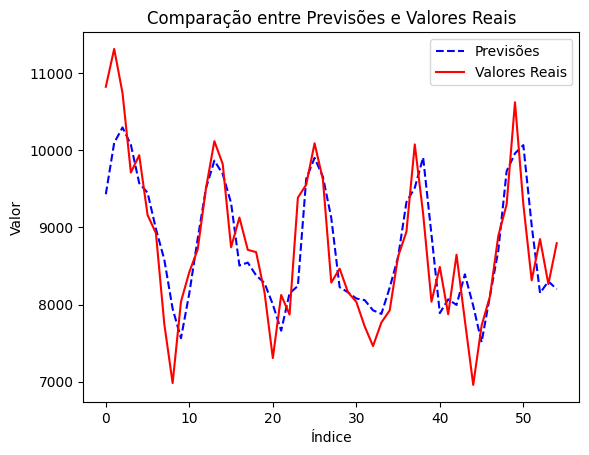

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], color='blue', linestyle='--', label='Previsões')
plt.plot(train_results['Actuals'], color='red', linestyle='-', label='Valores Reais')
plt.title('Comparação entre Previsões e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()


In [10]:
val_predictions = model2.predict(X_val1).flatten()

val_predictions_unscaled = escala.inverse_transform(val_predictions.reshape(-1, 1))
y_val1_unscaled = escala.inverse_transform(y_val1.reshape(-1, 1))

val_results = pd.DataFrame(data={'Val Predictions': val_predictions_unscaled.flatten(), 'Actuals': y_val1_unscaled.flatten()})
val_results

1/1 [==============================] - 0s 46ms/step


,Val Predictions,Actuals
0,8356.154297,7836.0
1,7895.502930,6892.0
2,7450.501465,7791.0
3,8076.790527,8192.0
4,8715.562500,9115.0


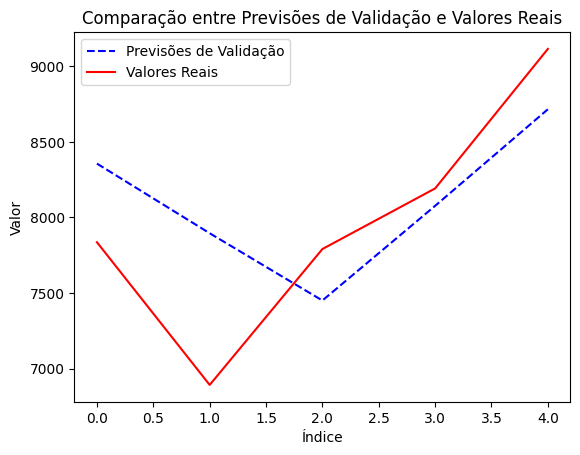

In [ ]:
plt.plot(val_results['Val Predictions'], color='blue', linestyle='--', label='Previsões de Validação')
plt.plot(val_results['Actuals'], color='red', linestyle='-', label='Valores Reais')
plt.title('Comparação entre Previsões de Validação e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()


In [11]:
test_predictions = model2.predict(X_test1).flatten()

test_predictions_unscaled = escala.inverse_transform(test_predictions.reshape(-1, 1))
y_test1_unscaled = escala.inverse_transform(y_test1.reshape(-1, 1))

test_results = pd.DataFrame(data={'Test Predictions': test_predictions_unscaled.flatten(), 'Actuals': y_test1_unscaled.flatten()})
test_results

1/1 [==============================] - 0s 40ms/step


,Test Predictions,Actuals
0,9855.914062,9434.0
1,10028.172852,10484.0
2,10004.218750,9827.0
3,9358.578125,9110.0
4,8783.966797,9070.0
5,8599.760742,8633.0
6,8383.586914,9240.0


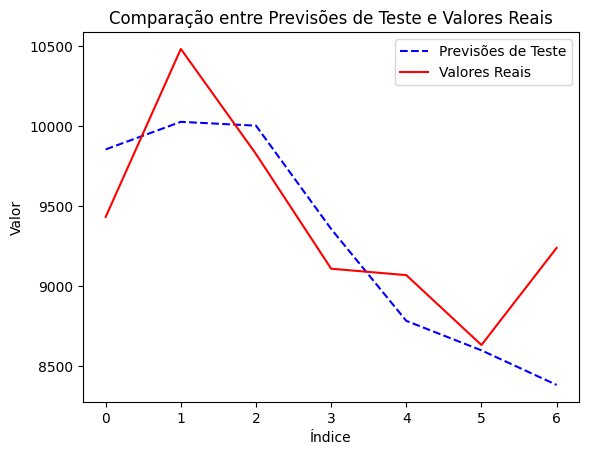

In [ ]:
plt.plot(test_results['Test Predictions'], color='blue', linestyle='--', label='Previsões de Teste')
plt.plot(test_results['Actuals'], color='red', linestyle='-', label='Valores Reais')
plt.title('Comparação entre Previsões de Teste e Valores Reais')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()


In [12]:
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:].values #getting the last sequence of known value
    inp = input_seq
    predictions = list()
    for _ in range(1, multisteps+1):
        inp = inp.reshape(1, timesteps, 1)
        yhat = model.predict(inp)
        yhat_inversed = scaler.inverse_transform(yhat)
        predictions.append(yhat_inversed[0][0])
        #prepare new input to forecast the next day
        inp = np.append(inp[0], yhat)
        inp = inp[-timesteps:]
    return predictions

def plot_forecast(data, forecasts):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data, color='green', label='Confirmed')
    plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    plt.title('Numero de mortes acidentais')
    plt.ylabel('Mortes Acidentais')
    plt.xlabel('Tempo')
    plt.legend()
    plt.show()     

In [13]:
forecasts = forecast(model2, bd, WINDOW_SIZE, multisteps=WINDOW_SIZE, scaler=escala)
forecasts

1/1 [==============================] - 0s 31ms/step


[8587.411, 8253.86, 8032.769, 7941.1807, 8013.414]

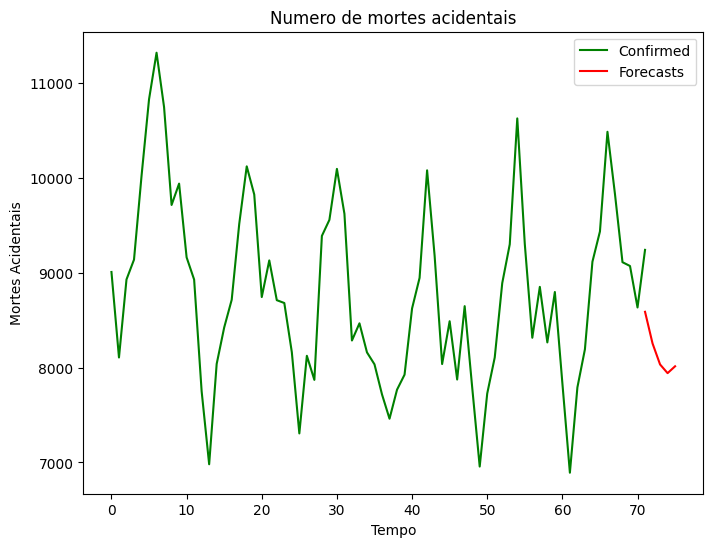

In [14]:
bd = pd.read_csv(r"USAccDeaths.csv")
bd.pop("Unnamed: 0")
bd
plot_forecast(bd["value"], forecasts)